## 1. Data Setup

In [1]:
import h5py
import numpy as np

with h5py.File('training_data.h5', 'r') as f:
    flux = f['flux'][:]
    params = f['parameters'][:]
    labels = f['labels'][:]

class_names = ['sw', 'fs', 'msh', 'msp', 'ps', 'lobe']
class_to_idx = {'sw': 0, 'fs': 1, 'msh': 2, 'msp': 3, 'ps': 4, 'lobe':5}

PARAM_SIZE = params.shape[2]

import torch

X1_tensor = torch.from_numpy(flux).type(torch.float) # float is float32
X2_tensor = torch.from_numpy(params).type(torch.float) # float is float32
y_tensor = torch.from_numpy(labels).type(torch.LongTensor).squeeze()

nan_mask = torch.isnan(X2_tensor)
num_nan = torch.sum(nan_mask).item()
print("Number of NaNs:", num_nan)

# Replace NaN values with 0
X2_tensor = torch.nan_to_num(X2_tensor, nan=0.0)

# change to color, height, width, torch format
X1_tensor = torch.permute(X1_tensor, (0, 2, 1))
X1_tensor.size()

X2_tensor = torch.permute(X2_tensor, (0, 2, 1))

from sklearn.model_selection import train_test_split

# Split indices for training and testing
train_indices, test_indices = train_test_split(range(len(X1_tensor)), test_size=0.2, random_state=42)

# Use indices to split the datasets
X1_train, X1_test = X1_tensor[train_indices], X1_tensor[test_indices]
X2_train, X2_test = X2_tensor[train_indices], X2_tensor[test_indices]
y_train, y_test = y_tensor[train_indices], y_tensor[test_indices]


def min_max_scaling(tensor, feature_range=(0, 1)):
  """
  Scales a tensor to a specified range using min-max scaling.

  Args:
    tensor (torch.Tensor): The input tensor.
    feature_range (tuple, optional): The desired range for the scaled tensor. Defaults to (0, 1).

  Returns:
    torch.Tensor: The scaled tensor.
  """
  min_val = tensor.min()
  max_val = tensor.max()
  scaled_tensor = (tensor - min_val) / (max_val - min_val)

  #Adjust to the desired range
  scaled_tensor = scaled_tensor * (feature_range[1] - feature_range[0]) + feature_range[0]
  return scaled_tensor


min_vals_X1 = X1_train.min()
max_vals_X1 = X1_train.max()
X1_train = min_max_scaling(X1_train, feature_range=(0, 1))
min_vals_X1, max_vals_X1
X1_test = (X1_test - min_vals_X1) / (max_vals_X1 - min_vals_X1)

min_vals_X2 = torch.zeros(PARAM_SIZE)
max_vals_X2 = torch.zeros(PARAM_SIZE)

for i in range(0,PARAM_SIZE):
    min_vals_X2[i] = X2_train[:,i,:].min()
    max_vals_X2[i] = X2_train[:,i,:].max()
    if i == 2:
        X2_train[:,i,:] = min_max_scaling(X2_train[:,i,:], feature_range=(-1, 1))
        X2_test[:,i,:] = (X2_test[:,i,:] - min_vals_X2[i]) / (max_vals_X2[i] - min_vals_X2[i])
        #Adjust to the desired range
        X2_test[:,i,:] = X2_test[:,i,:]*2. - 1.0 # (-1,1)
    else:     
        X2_train[:,i,:] = min_max_scaling(X2_train[:,i,:], feature_range=(0, 1))
        X2_test[:,i,:] = (X2_test[:,i,:] - min_vals_X2[i]) / (max_vals_X2[i] - min_vals_X2[i]) #(0,1)

X1_train = X1_train.unsqueeze(dim=1)
X1_test = X1_test.unsqueeze(dim=1)

Number of NaNs: 6


In [2]:
X1_train.shape, X1_test.shape, X2_train.shape, X2_test.shape, y_train.shape, y_test.shape

(torch.Size([473, 1, 32, 40]),
 torch.Size([119, 1, 32, 40]),
 torch.Size([473, 3, 40]),
 torch.Size([119, 3, 40]),
 torch.Size([473]),
 torch.Size([119]))

In [3]:
min_vals_X1, max_vals_X1, min_vals_X2, max_vals_X2

(tensor(0.),
 tensor(1.5701e+08),
 tensor([  0.6576,  19.5559, -23.5244]),
 tensor([  85.0814, 9750.4180,   16.6774]))

In [4]:
X2_train[:,2, 1:5]

tensor([[-0.9581, -0.9581, -0.9581, -0.9580],
        [ 0.7046,  0.7046,  0.7046,  0.7046],
        [ 0.3690,  0.3690,  0.3689,  0.3689],
        ...,
        [ 0.7052,  0.7052,  0.7052,  0.7052],
        [ 0.8247,  0.8247,  0.8247,  0.8247],
        [-0.9978, -0.9978, -0.9978, -0.9979]])

In [5]:
np.average(X2_train[242, 0, :]), np.average(X2_train[242, 1, :]), np.average(X2_train[242, 2, :])

(0.058736037, 0.00694554, 0.69472575)

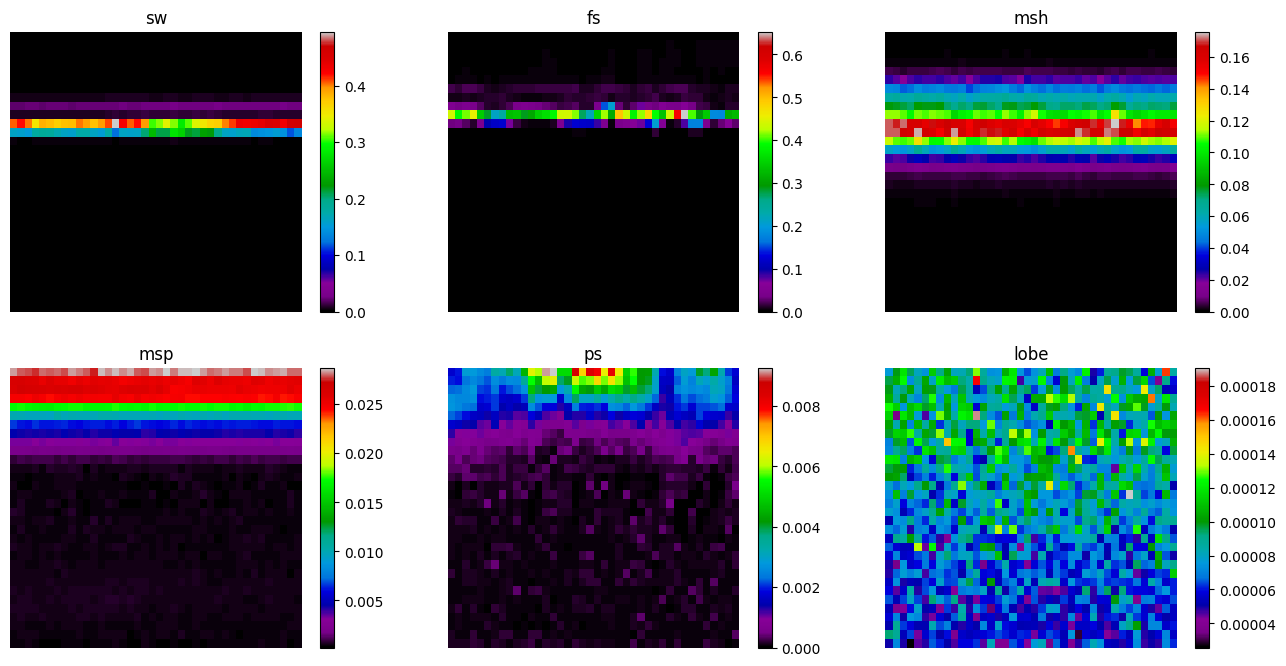

In [6]:
class_names = ['sw', 'fs', 'msh', 'msp', 'ps', 'lobe']
# Plot more images

# picked_indices = []
# picked_values = []

# for val in range(6):  # 0 to 5
#     indices = (y_train == val).nonzero(as_tuple=True)[0]  # all positions of val
#     random_idx = indices[torch.randint(len(indices), (1,))]  # pick one at random
#     picked_indices.append(random_idx.item())
#     picked_values.append(val)

# print("Picked indices:", picked_indices)
# print("Picked values:", picked_values)

import matplotlib.pyplot as plt
indices = [174, 118, 158, 68, 49, 466]
values = [0, 1, 2, 3, 4, 5]
torch.manual_seed(42)
fig = plt.figure(figsize=(16, 8))
rows, cols = 2, 3
for i in range(1, rows * cols + 1):
    # random_idx = torch.randint(0, len(X1_train), size=[1]).item()
    img, label = X1_train[indices[i-1]], y_train[indices[i-1]]
    fig.add_subplot(rows, cols, i)
    plt.pcolormesh(img.squeeze(), cmap='nipy_spectral', shading="auto")
    plt.colorbar()
    # plt.clim(0,0.25)
    plt.title(class_names[label])
    plt.axis(False);
    plt.savefig('Fluxexamples.png')

In [7]:
# indices = (y_train == 1).nonzero(as_tuple=True)[0]
# indices

In [8]:
# fig = plt.figure(figsize=(16, 8))
# rows, cols = 5, 5
# for i in range(1, rows * cols + 1):
#     # random_idx = torch.randint(0, len(X1_train), size=[1]).item()
#     img, label = X1_train[indices[i-1]], y_train[indices[i-1]]
#     fig.add_subplot(rows, cols, i)
#     plt.pcolormesh(img.squeeze(), cmap='nipy_spectral', shading="auto")
#     plt.colorbar()
#     # plt.clim(0,0.25)
#     plt.title(class_names[label])
#     plt.axis(False);

## 2. Model

In [9]:
import torch
from torch import nn

# Define the CNN model for flux data only
class FluxCNNModel(nn.Module):
    def __init__(self):
        super(FluxCNNModel, self).__init__()
        self.conv2d_1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2d_2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2d_3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(64 * 5 * 4, 64)  # Flattened size for input image size (1, 40, 32)
        self.dropout = nn.Dropout(p=0.5) # to avoid overfitting
        self.output = nn.Linear(64, 6)

    def forward(self, x1):
        x1 = self.conv2d_1(x1)
        x1 = self.conv2d_2(x1)
        x1 = self.conv2d_3(x1)
        x1 = torch.flatten(x1, start_dim=1)
        x1 = self.fc1(x1)
        x = self.output(x1)
        return x

# Initialize model
model = FluxCNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

FluxCNNModel(
  (conv2d_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2d_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2d_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1280, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=F

In [10]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Simulated plasma parameter data
# Shape: (num_samples, num_channels, sequence_length)
 # X2_train torch.Size([473, 3, 40]),
 # X2_test torch.Size([119, 3, 40]),

X2_train_avg = np.array(X2_train.mean(axis=2))   # shape becomes (473, 3)
X2_test_avg = np.array(X2_test.mean(axis=2))     # shape becomes (119, 3)

# Labels
# y_train and y_test, shapes 473, 119 in Torch Tensor Form

# Train RF
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X2_train_avg, np.array(y_train))

# Predict on new data
# Evaluate
y_pred = rf.predict(X2_test_avg)
print(classification_report(np.array(y_test), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        17
           3       0.96      1.00      0.98        22
           4       1.00      0.96      0.98        24
           5       1.00      1.00      1.00        17

    accuracy                           0.99       119
   macro avg       0.99      0.99      0.99       119
weighted avg       0.99      0.99      0.99       119



In [11]:
rf.predict_proba(X2_test_avg).shape

(119, 6)

In [12]:
#model.summary()

## 3. Training 

In [13]:
from torchmetrics import Accuracy

# setup metric and make sure it's on target device
acc_fn = Accuracy(task="multiclass", num_classes=6)

results = {"epochs": [],
           "train_loss": [],
           "train_acc": [],
           "test_loss": [],
           "test_acc": []}

# Training loop
num_epochs = 15
batch_size = 8
num_samples = len(X1_train)
for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    # print(epoch)
    for i in range(0, num_samples-1, batch_size):
        batch_X1 = X1_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        outputs = model(batch_X1)

        loss = criterion(outputs, batch_y)
        train_loss += loss
        train_acc += acc_fn(outputs.argmax(dim=1), batch_y)
        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss.item():.4f}, acc: {train_acc.item()*100:.2f}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= (len(X1_train)/batch_size)
    train_acc /= (len(X1_train)/batch_size)
    print(f"Epoch [{epoch+1}/{num_epochs}]: Train Loss: {train_loss.item():.4f}: Train acc: {train_acc.item()*100:.2f}%")
    results["epochs"].append(epoch)
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)


    test_loss, test_acc = 0, 0
    # Put model into evaluation mode
    model.eval()

    with torch.inference_mode():
        for i in range(0, len(X1_test), batch_size):
            batch_X1 = X1_test[i:i+batch_size]
            batch_y = y_test[i:i+batch_size]
            # print(batch_y)

            test_pred = model(batch_X1)
            # print(test_pred.argmax(dim=1))
            test_loss += criterion(test_pred , batch_y)
            test_acc += acc_fn(test_pred.argmax(dim=1), batch_y)

        # test loss and accuracy average per batch
        test_loss /= (len(X1_test)/batch_size)
        test_acc /= (len(X1_test)/batch_size)
        print(f"\nEpoch [{epoch+1}/{num_epochs}]: Test loss: {test_loss:.4f}: Test acc: {test_acc*100:.2f}%\n")
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

        # if test_acc > 0.98:  # Condition to exit loop
        if test_loss < 0.05:  # Condition to exit loop
            print("Stopping early: Accuracy exceeded threshold!")
            break  # Exiting the loop
print("Training complete!")

Epoch [1/15]: Train Loss: 1.7907: Train acc: 16.28%

Epoch [1/15]: Test loss: 1.8108: Test acc: 14.29%

Epoch [2/15]: Train Loss: 1.7862: Train acc: 17.76%

Epoch [2/15]: Test loss: 1.7606: Test acc: 33.25%

Epoch [3/15]: Train Loss: 1.0458: Train acc: 55.39%

Epoch [3/15]: Test loss: 0.6336: Test acc: 82.23%

Epoch [4/15]: Train Loss: 0.4481: Train acc: 78.44%

Epoch [4/15]: Test loss: 0.2938: Test acc: 82.23%

Epoch [5/15]: Train Loss: 0.2510: Train acc: 92.18%

Epoch [5/15]: Test loss: 0.2450: Test acc: 95.68%

Epoch [6/15]: Train Loss: 0.2228: Train acc: 92.60%

Epoch [6/15]: Test loss: 0.1189: Test acc: 96.64%

Epoch [7/15]: Train Loss: 0.1771: Train acc: 93.87%

Epoch [7/15]: Test loss: 0.2163: Test acc: 96.64%

Epoch [8/15]: Train Loss: 0.1584: Train acc: 94.08%

Epoch [8/15]: Test loss: 0.0977: Test acc: 96.64%

Epoch [9/15]: Train Loss: 0.1301: Train acc: 93.87%

Epoch [9/15]: Test loss: 0.0890: Test acc: 96.64%

Epoch [10/15]: Train Loss: 0.1128: Train acc: 95.35%

Epoch [10/

In [14]:
from tqdm.auto import tqdm


# Make predictions with trained CNN model and rf
num_samples = len(X1_test)
y_pred_cnn = []
model.eval()
with torch.inference_mode():
    for i in tqdm(range(0, num_samples, batch_size)):
        batch_X1 = X1_test[i:i+batch_size]
        batch_y = y_test[i:i+batch_size]
        
        y_logit = model(batch_X1)
        y_cnn = torch.softmax(y_logit, dim=1)

        y_pred_cnn.append(y_cnn)

# # prediction from cnn model
y_pred_cnn_tensor = torch.cat(y_pred_cnn) # shape: (119, 6)
# y_pred_cnn_tensor.shape

# #prediction from random forest
rf_output = rf.predict_proba(X2_test_avg) # shape: (119, 6)
# rf_output

# Fuse probablities (e.g., by averaging)

combined_output= (y_pred_cnn_tensor.numpy() + rf_output) / 2
y_pred_numpy = np.argmax(combined_output, axis=1)

y_pred_tensor = torch.Tensor(y_pred_numpy)
y_pred_tensor

  0%|          | 0/15 [00:00<?, ?it/s]

tensor([1., 3., 0., 5., 3., 4., 3., 2., 0., 2., 3., 4., 1., 1., 0., 5., 1., 0.,
        0., 0., 5., 1., 5., 4., 2., 1., 3., 4., 2., 2., 5., 4., 4., 4., 3., 0.,
        4., 1., 2., 1., 2., 0., 5., 2., 3., 2., 1., 3., 4., 1., 4., 2., 4., 1.,
        4., 3., 3., 3., 5., 5., 1., 0., 0., 5., 4., 2., 0., 4., 3., 5., 3., 2.,
        4., 3., 0., 2., 5., 0., 3., 4., 4., 5., 0., 1., 4., 4., 4., 2., 2., 4.,
        3., 3., 2., 3., 0., 5., 5., 3., 2., 3., 1., 0., 3., 4., 0., 5., 3., 1.,
        3., 0., 4., 5., 5., 0., 1., 0., 1., 0., 0.])

mlxtend version: 0.23.3


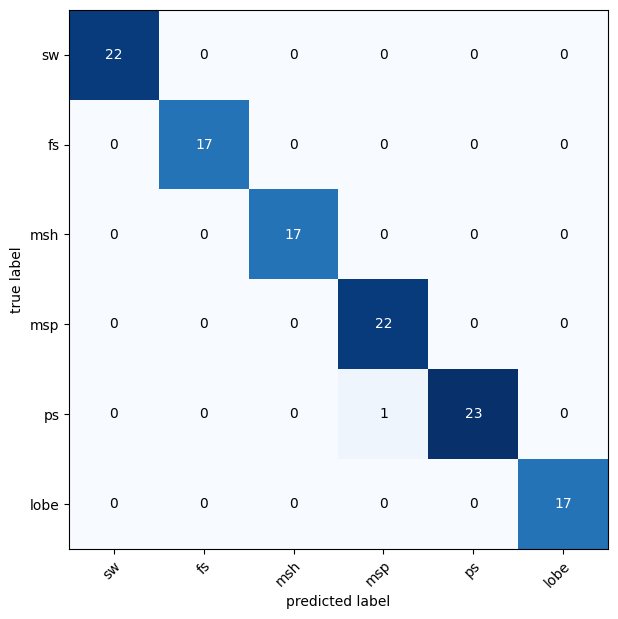

In [15]:
import matplotlib.pyplot as plt
import torchmetrics, mlxtend
print(f"mlxtend version: {mlxtend.__version__}")

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# setup confusion matrix instance and compare predictions to target
confmat = ConfusionMatrix(num_classes=6, task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_test)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10,7));
fig.savefig('ConfMatrix.png', dpi=fig.dpi)
plt.show()

n_classes 6
AUC macro average :0.9956686712485682
AUC micro average :0.9949579831932773


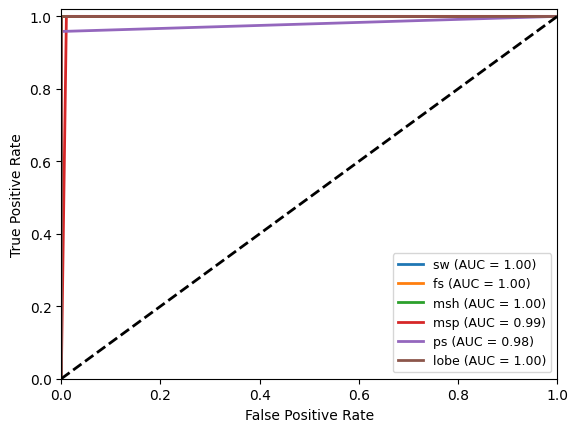

In [16]:
association = {0:'sw', 1:'fs', 2:'msh', 3:'msp', 4:'ps', 5:'lobe'}

from utilities import roc_plot_rf

fig = roc_plot_rf(y_pred_tensor, y_test, association=association)
plt.show()

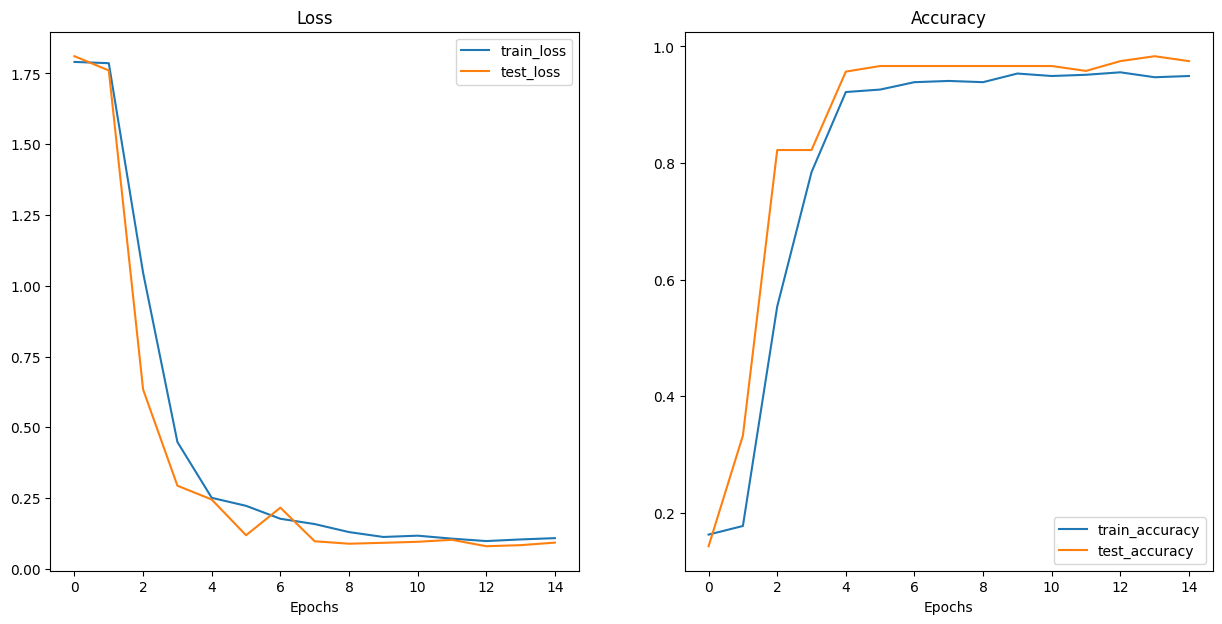

In [17]:
# This is only from CNN model

from utilities import plot_loss_curves

plot_loss_curves(results)

In [18]:
from torchmetrics import F1Score

# Initialize F1Score for multiclass task
f1_metric_multiclass = F1Score(task="multiclass", num_classes=6, average="macro") # or "micro", "weighted"

# Compute F1 score
f1_score_multiclass = f1_metric_multiclass(y_pred_tensor, y_test)
print(f"Multiclass F1 Score (macro avg): {f1_score_multiclass}")

Multiclass F1 Score (macro avg): 0.9927502870559692


In [19]:
from torchmetrics import functional  #precision_recall

from torchmetrics.classification import MulticlassPrecision
metric = MulticlassPrecision(num_classes=6)

metric(y_pred_tensor, y_test)

mcp = MulticlassPrecision(num_classes=6, average=None)
mcp(y_pred_tensor, y_test)

tensor([1.0000, 1.0000, 1.0000, 0.9565, 1.0000, 1.0000])

In [20]:
from torchmetrics.classification import MulticlassRecall

metric = MulticlassRecall(num_classes=6)
metric(y_pred_tensor, y_test)

mcr = MulticlassRecall(num_classes=6, average=None)
mcr(y_pred_tensor, y_test)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9583, 1.0000])

In [21]:
print(classification_report(y_test, y_pred_tensor))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        17
           3       0.96      1.00      0.98        22
           4       1.00      0.96      0.98        24
           5       1.00      1.00      1.00        17

    accuracy                           0.99       119
   macro avg       0.99      0.99      0.99       119
weighted avg       0.99      0.99      0.99       119



## 4. Save the model

In [22]:
# from pathlib import Path

# # Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
# MODEL_PATH = Path("models")
# MODEL_PATH.mkdir(parents=True, # create parent directories if needed
#                  exist_ok=True # if models directory already exists, don't error
# )

# # Create cnn model save path
# CNN_MODEL_NAME = "model04_fluxsteps10_dropout.pth"
# CNN_MODEL_SAVE_PATH = MODEL_PATH / CNN_MODEL_NAME

# # Save the cnn model state dict
# print(f"Saving CNN model to: {CNN_MODEL_SAVE_PATH}")
# torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
#            f=CNN_MODEL_SAVE_PATH)

# import joblib
# # Create rf model save path
# RF_MODEL_NAME = "model04_parameters.pkl"
# RF_MODEL_SAVE_PATH = MODEL_PATH / RF_MODEL_NAME

# # Save the RF model
# joblib.dump(rf, RF_MODEL_SAVE_PATH )
# print(f"Saving RF model to: {RF_MODEL_SAVE_PATH}")



In [33]:
# Instantiate a fresh instance of multiinputmodel
loaded_CNN = FluxCNNModel()
# RFModel = rf()



# Load model state dict
loaded_CNN.load_state_dict(torch.load(f="./models/model03_fluxsteps10_dropout.pth"))

print(f"Loaded model:\n{FluxCNNModel}")

# Load RF model
import joblib
from sklearn.ensemble import RandomForestClassifier
RF_MODEL_SAVE_PATH = './models/model03_parameters.pkl'
loaded_rf = joblib.load(RF_MODEL_SAVE_PATH)
print("Loaded model:", loaded_rf)

model = loaded_CNN
rf = loaded_rf

Loaded model:
<class '__main__.FluxCNNModel'>
Loaded model: RandomForestClassifier(random_state=42)


In [34]:
# from predict import predictions_cnn_rf
# trange = ['2015-09-19/00:07:00', '2015-09-19/20:00:00'] # flank
# predictions_cnn_rf(model, rf, trange)

In [35]:
import os
import torch
from torch import nn
# path for data 
os.environ["SPEDAS_DATA_DIR"] = "/Volumes/datadir/mmsdata"  #"/Users/naah5403/data"

import pyspedas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import more_itertools
import xarray as xr
from pytplot import tplot, del_data, options, get_data, get, store_data, ylim, tplot_options, tlimit
from pyspedas import tinterpol, time_string

def predictions_cnn_rf(cnn_model:torch.nn.Module, rf_model, trange):

    tname = trange[0].replace('/','_').replace('-','').replace(':','')
    probe = '1'
    pyspedas.mms.fgm(trange=trange, data_rate='srvy', probe=probe)
    pyspedas.mms.fpi(trange=trange,center_measurement=True, data_rate='fast',datatype=['dis-moms'], probe=probe)
    pyspedas.mms.mec(trange=trange, data_rate='srvy', probe=probe)
    
    BgseN ='mms1_fgm_b_gse_srvy_l2'
    DeniN = 'mms1_dis_numberdensity_fast'
    ViN = 'mms1_dis_bulkv_gse_fast'
    TiperpN = 'mms1_dis_tempperp_fast'
    TiparaN = 'mms1_dis_temppara_fast'
    posN = 'mms1_mec_r_gse'
    
    omni_flux = get_data('mms1_dis_energyspectr_omni_fast')
    energy = get_data('mms1_dis_energy_fast')
    
    # Interpol to ion fpi time 30ms
    tinterpol(BgseN, DeniN)
    tinterpol(posN, DeniN)
    
    #times, Bgse = get_data(BgseN+'-itrp')
    
    ni = get_data(DeniN)
    B = get_data(BgseN+'-itrp')
    Vi = get_data(ViN)
    Tiperp = get_data(TiperpN)
    Tipara = get_data(TiparaN)
    pos = get_data(posN+'-itrp')
    
    df_time = time_string(ni.times)
    df_ni = pd.DataFrame(ni.y, columns = ['ni'],index = [df_time])
    df_B = pd.DataFrame(B.y, columns = ['Bx','By','Bz','Btot'],index = [df_time])
    df_Vi = pd.DataFrame(Vi.y, columns = ['Vx','Vy','Vz'],index = [df_time])
    df_Vitot = pd.DataFrame(np.linalg.norm(df_Vi.values, axis=1), columns = ['vitot'], index = [df_time])
    df_Tiperp = pd.DataFrame(Tiperp.y, columns = ['Tiperp'],index = [df_time])
    df_Tipara = pd.DataFrame(Tipara.y, columns = ['Tipara'],index = [df_time])
    df_Ti = pd.concat([df_Tiperp,df_Tipara], axis=1)
    df_Titot = df_Ti.mean(axis=1)
    df_pos = pd.DataFrame(pos.y/6378., columns = ['X','Y','Z'],index = [df_time])
    
    df_final = pd.concat([df_B, df_ni, df_Vi, df_Vitot, df_Ti, df_Titot, df_pos], axis=1)
    df_final.columns = ['bx', 'by', 'bz', 'btot', 'ni', 'vix', 'viy', 'viz', 'vitot', 'Tiperp', 'Tipara', 'Titot', 'X', 'Y', 'Z']
    
    
    
    block_size = 40
    blocks = list(more_itertools.chunked(df_final.values, block_size))
    blocks = [np.array(x) for x in blocks]
    
    x_input_all = np.array(blocks[:-1])
    
    timestamps = list(more_itertools.chunked(df_final.index, block_size))
    timestamps = np.array(timestamps[:-1])
    
    index = pd.DatetimeIndex(timestamps[:,0,0])
    
    block_size = 40
    blocks = list(more_itertools.chunked(omni_flux.y, block_size))
    blocks = [np.array(x) for x in blocks]
    
    x_input_flux = np.array(blocks[:-1])
    
    
    X1 = x_input_flux
    
    X2_1 = x_input_all[:,:,3]  # btot
    X2_1 = np.expand_dims(X2_1, axis=2)
    X2_2 = x_input_all[:,:,11:13]  # T_tot, X
    
    X2 = np.concatenate((X2_1, X2_2), axis=2)
    
    import torch
    X1_tensor_test = torch.from_numpy(np.array(X1)).type(torch.float) # float is float32
    X2_tensor_test = torch.from_numpy(np.array(X2)).type(torch.float) # float is float32
    
    nan_mask = torch.isnan(X2_tensor_test)
    num_nan = torch.sum(nan_mask).item()
    print("Number of NaNs:", num_nan)
    
    # Replace NaN values with 0
    X2_tensor_test = torch.nan_to_num(X2_tensor_test, nan=0.0)
    
    min_vals_X1 = torch.tensor(0.)
    max_vals_X1 = torch.tensor(1.5701e+08)
    min_vals_X2 = torch.tensor([0.6576, 19.5559, -23.5244])
    max_vals_X2 = torch.tensor([85.0814, 9750.4180, 16.6774])
    PARAM_SIZE = 3
    
    X1_tensor_test = (X1_tensor_test - min_vals_X1) / ( max_vals_X1 - min_vals_X1)
    
    
    for i in range(0,PARAM_SIZE):
        if i ==2 :
            X2_tensor_test[:,:,i] = (X2_tensor_test[:,:,i] - min_vals_X2[i]) / ( max_vals_X2[i] - min_vals_X2[i])
            X2_tensor_test[:,:,i] = X2_tensor_test[:,:,i]*2.0 - 1.0
        else:
            X2_tensor_test[:,:,i] = (X2_tensor_test[:,:,i] - min_vals_X2[i]) / ( max_vals_X2[i] - min_vals_X2[i])
    
    
    # change to color, height, width, torch format
    X1_tensor_test = torch.permute(X1_tensor_test, (0, 2, 1))
    X1_tensor_test.size()
    
    X2_tensor_test = torch.permute(X2_tensor_test, (0, 2, 1))
    X2_test_avg = np.array(X2_tensor_test.mean(axis=2))     # shape becomes (length, 3)
    
    
    X1_tensor_test = X1_tensor_test.unsqueeze(dim=1)
    
    # Make predictions with trained model
    from tqdm.auto import tqdm	
    
    # Make predictions with trained CNN model and rf
    num_samples = len(X1_tensor_test)
    batch_size = 8
    
    y_pred_cnn = []
    cnn_model.eval()
    with torch.inference_mode():
        for i in tqdm(range(0, num_samples, batch_size)):
            batch_X1 = X1_tensor_test[i:i+batch_size]
            
            y_logit = cnn_model(batch_X1)
            y_cnn = torch.softmax(y_logit, dim=1)
    
            y_pred_cnn.append(y_cnn)
    
    # # prediction from cnn model
    y_pred_cnn_tensor = torch.cat(y_pred_cnn)
    # y_pred_cnn_tensor.shape
    
    
    # prediction from random forest
    rf_output = rf_model.predict_proba(X2_test_avg)

    # prediction from cnn only
    y_cnn = np.argmax(y_pred_cnn_tensor.numpy(), axis=1)
   # Find indexes where x > 0 and label is 4 or 5, replace with 2 PS or LOBE to MSP
    indices_day = np.where((X2_test_avg[:,2] > 0) & ((y_cnn == 4) | (y_cnn == 5)))[0]
    y_cnn[indices_day] = 3   

    y_cnn = pd.DataFrame(y_cnn)    
    y_cnn = y_cnn.set_index(index)


    # prediction from rf only
    y_rf = np.argmax(rf_output, axis=1)
    y_rf = pd.DataFrame(y_rf)    
    y_rf = y_rf.set_index(index)

    # Fuse probablities (e.g., by averaging)
    
    combined_output= (y_pred_cnn_tensor.numpy() + rf_output ) / 2
    y_pred_numpy = np.argmax(combined_output, axis=1)

  # # Find indexes where x > 0 and label is 4 or 5, replace with 2 PS or LOBE to MSP
  #   indices_day = np.where((X2_test_avg[:,2] > 0) & ((y_pred_numpy == 4) | (y_pred_numpy == 5)))[0]
  #   y_pred_numpy[indices_day] = 3   
  
    # # Find indexes where x < 0 and label is 3, replace with 4
    # indices_tail = np.where((X2_test_avg[:,2] < 0) & (y_pred_numpy == 3) )[0]
    # y_pred_numpy[indices_tail] = 4   

    
    y_pred_tensor = torch.Tensor(y_pred_numpy)
    # print(y_pred_tensor)
    # print(X2_test_avg[:,2])

    def replace_pair_values(tensor, pair_list, new_value):
        """
        pair_list: list of (a,b) pairs to consider (will treat (a,b) and (b,a) the same)
        new_value: scalar to set on both elements of each matched pair
        """
        # Build mask for pairs in y[:-1] vs y[1:]
        a = tensor[:-1]
        b = tensor[1:]
        # Start with all False
        mask_pairs = torch.zeros_like(a, dtype=torch.bool)
        for p in pair_list:
            p0, p1 = p
            mask_pairs |= ((a == p0) & (b == p1)) | ((a == p1) & (b == p0))
    
        # Expand to full-length mask marking both members of each matched pair
        mask_full = torch.zeros_like(tensor, dtype=torch.bool)
        mask_full[:-1] |= mask_pairs
        mask_full[1:]  |= mask_pairs
    
        tensor[mask_full] = new_value
        return tensor

    # Sequentially apply the same groups as your original code:
    # 1) (2<->3) -> 6  MSH <-> MSP  -> MP
    replace_pair_values(y_pred_tensor, [(2,3)], 6)
    
    # 2) (0<->2) or (1<->2) -> 7  SW <-> MSH -> BS
    replace_pair_values(y_pred_tensor, [(0,2), (1,2)], 7)
    
    # 3) (4<->5) -> 8 PS <-> LOBE -> PSBL
    replace_pair_values(y_pred_tensor, [(4,5)], 8)

    
    y_pred_tensor = pd.DataFrame(y_pred_tensor)
    y_pred_tensor = y_pred_tensor.set_index(index)

    B = pd.DataFrame(X2_test_avg[:,0])
    B = B.set_index(index)
    T = pd.DataFrame(X2_test_avg[:,1])
    T = T.set_index(index)
    X = pd.DataFrame(X2_test_avg[:,2])
    X = X.set_index(index)

    
    figure, axis = plt.subplots(4, 1,  figsize=(20, 16), sharex=True, constrained_layout=True) #sharex=True
    pcm=axis[0].pcolormesh(np.array(time_string(energy.times)).astype("datetime64[ns]"),energy.y[0],
                                   np.log10(np.transpose(omni_flux.y[:,:])),cmap='nipy_spectral',shading='auto')
    axis[0].set_yscale('log')
    figure.colorbar(pcm, ax=axis[0], label="$keV/(cm^2~s~sr~keV)$", pad=0)
    # pcm.set_clim(3,6)
    
    size=14
    plt.rc('font', size=size)          # controls default text sizes
    plt.rc('axes', titlesize=size)     # fontsize of the axes title
    plt.rc('axes', labelsize=size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=size+2)    # legend fontsize
    plt.rc('figure', titlesize=size)  # fontsize of the figure title
    
    axis[1].plot(index, B, 'ok', label='Magnetic Field')
    axis[1].plot(index, T, 'or', label='Temperature')
    axis[1].plot(index, X, 'ob', label='Position')
    axis[1].grid()
    axis[1].set_ylabel('Normalized Parameters')
    axis[1].legend()    
    

    axis[2].plot(index, y_rf, 'oc', label='RF')
    axis[2].plot(index, y_cnn, 'om', label='CNN')
    # axis[2].plot(index, y_pred_tensor, 'ok')
    # axis[2].yaxis.set_ticks(np.arange(0,9,1))
    # axis[2].yaxis.set_ticklabels(['SW', 'FS', 'MSH', 'MSP', 'PS', 'LOBE', 'MP', 'BS', 'PSBL'])
    axis[2].yaxis.set_ticks(np.arange(0,6,1))
    axis[2].yaxis.set_ticklabels(['SW', 'FS', 'MSH', 'MSP', 'PS', 'LOBE'])
    axis[2].grid()
    axis[2].set_ylabel('RF and CNN Predictions')
    axis[2].legend()    
    
    axis[3].plot(index, y_pred_tensor, 'ok')
    axis[3].yaxis.set_ticks(np.arange(0,9,1))
    axis[3].yaxis.set_ticklabels(['SW', 'FS', 'MSH', 'MSP', 'PS', 'LOBE', 'MP', 'BS', 'PSBL'])
    axis[3].grid()
    axis[3].set_ylabel('Predictions')
    # axis[1].set_xlabel('time (UTC)')
    
    plt.savefig("CNN_RF02_Case_"+tname+".png")
    plt.show()




28-Aug-25 14:07:27: Loading /Volumes/datadir/mmsdata/mms/mms1/fgm/srvy/l2/2019/12/mms1_fgm_srvy_l2_20191207_v5.222.0.cdf
28-Aug-25 14:07:31: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2019/12/mms1_fpi_fast_l2_dis-moms_20191207040000_v3.4.0.cdf
28-Aug-25 14:07:31: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2019/12/mms1_fpi_fast_l2_dis-moms_20191207060000_v3.4.0.cdf
28-Aug-25 14:07:31: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2019/12/mms1_fpi_fast_l2_dis-moms_20191207080000_v3.4.0.cdf
28-Aug-25 14:07:31: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2019/12/mms1_fpi_fast_l2_dis-moms_20191207100000_v3.4.0.cdf
28-Aug-25 14:07:31: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2019/12/mms1_fpi_fast_l2_dis-moms_20191207120000_v3.4.0.cdf
28-Aug-25 14:07:31: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2019/12/mms1_fpi_fast_l2_dis-moms_20191207140000_v3.4.0.cdf
28-Aug-25 14:07:31: L

Number of NaNs: 0


  0%|          | 0/39 [00:00<?, ?it/s]

28-Aug-25 14:07:35: /var/folders/nr/rrbzw4215sdgt24vls1fg3hw0091p4/T/ipykernel_19218/2998681676.py:232: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.transpose(omni_flux.y[:,:])),cmap='nipy_spectral',shading='auto')



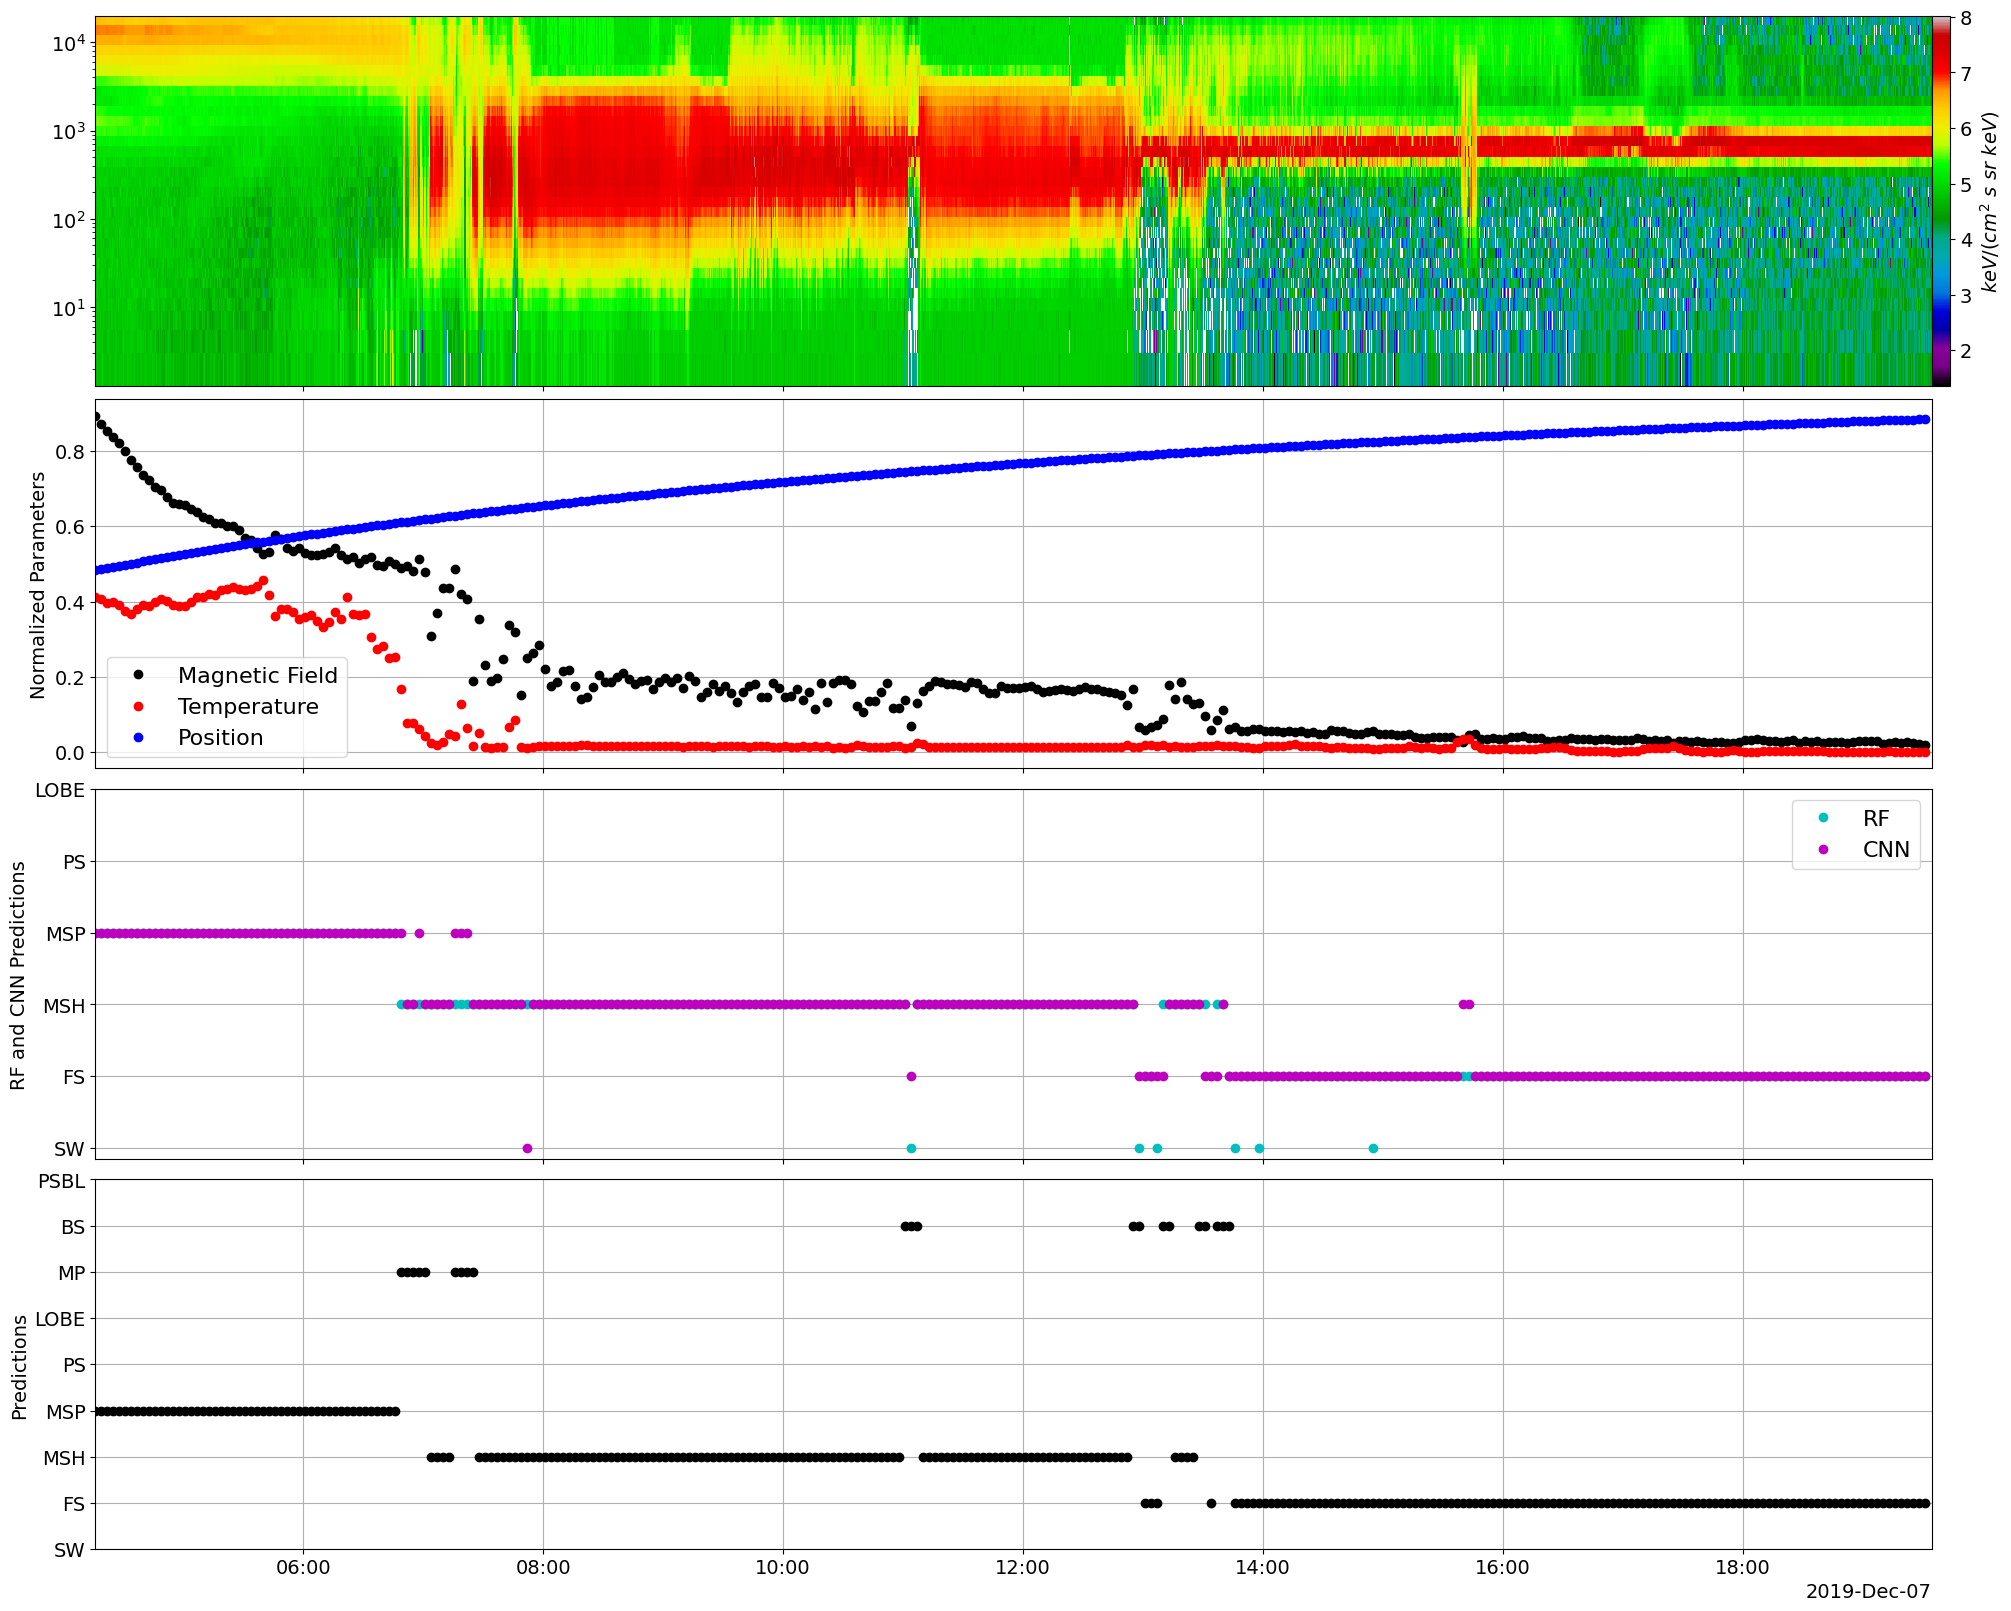

In [36]:
# import predict
# trange = ['2023-05-02/00:00:00', '2023-05-02/23:59:00']
# predict.predictions_cnn_rf(model, rf, trange)

# trange = ['2019-11-09/00:05:00', '2019-11-09/23:59:00']
trange = ['2019-12-07/00:05:00', '2019-12-07/23:59:00']
# trange = ['2022-01-09/00:00:00', '2022-01-09/23:59:00']
# trange = ['2023-04-17/00:00:00', '2023-04-17/23:59:00']
# trange = ['2023-05-02/00:00:00', '2023-05-02/23:59:00']
# trange = ['2025-03-10/00:00:00', '2025-03-10/23:59:00']
# trange = ['2017-01-31/00:00:00', '2017-01-31/23:59:00']

## nightside use case
# trange = ['2019-07-13/00:00:00', '2019-07-13/23:59:00']
# trange = ['2022-07-18/00:00:00', '2022-07-18/23:59:00']
# trange = ['2021-08-31/00:00:00', '2021-08-31/23:59:00']
# trange = ['2024-08-24/00:00:00','2024-08-24/23:59:00']


## flank use case
# trange = ['2015-09-15/00:08:00', '2015-09-15/20:00:00'] # flank
# trange = ['2015-09-19/00:07:00', '2015-09-19/20:00:00'] # flank

predictions_cnn_rf(model, rf, trange)